# Import Libraries

In [1270]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use("ggplot")

# Download Data & Create Indicators

In [1271]:
df=yf.download("ELET6.SA",progress=False)
df["SMA9"]=df["Close"].rolling(9).mean()
df["SMA21"]=df["Close"].rolling(21).mean()
df["Relation"]=df["SMA9"]/df["SMA21"]
df.tail(5)
# ewm span =17 == ewm 9
# ewm span =41 ==ewm 21


,Open,High,Low,Close,Adj Close,Volume,SMA9,SMA21,Relation
Date,,,,,,,,,
2021-08-05,40.639999,40.880001,39.330002,39.799999,39.799999,1581600,41.160000,42.189048,0.975609
2021-08-06,39.790001,41.360001,39.660000,40.900002,40.900002,1177000,41.052222,42.104762,0.975002
2021-08-09,40.880001,41.200001,40.150002,40.439999,40.439999,1708200,40.874444,42.016667,0.972815
2021-08-10,40.799999,40.799999,39.720001,39.860001,39.860001,1375600,40.562222,41.870476,0.968755
2021-08-11,39.939999,40.080002,39.320000,39.950001,39.950001,1431500,40.337778,41.739524,0.966417


# Ploting the Indicator

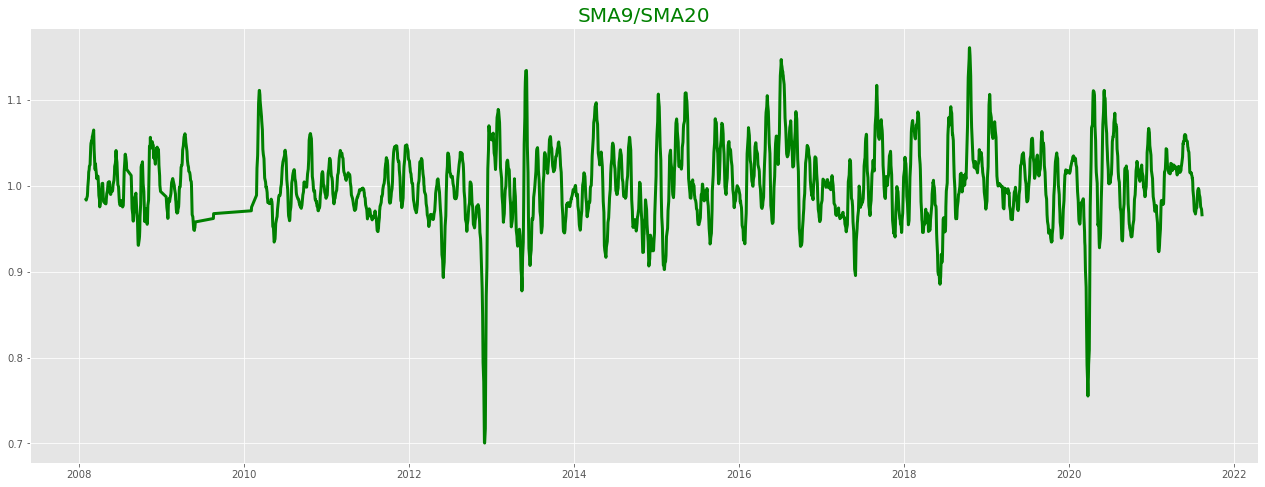

In [1272]:
plt.figure(figsize=(22,8))
plt.plot(df["Relation"],color="green",linewidth=3)
plt.title("SMA9/SMA20",fontsize=20,color="green")

plt.show()

# Ploting Stock Prices

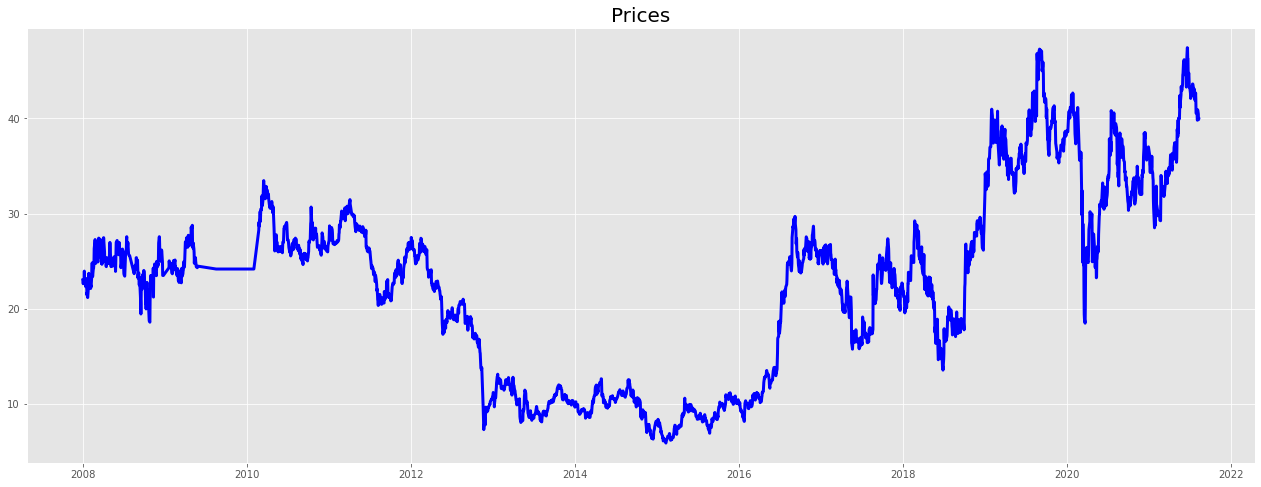

In [1273]:
plt.figure(figsize=(22,8))
plt.plot(df["Close"],color="blue",linewidth=3)
plt.title("Prices",fontsize=20)
plt.show()

# Creating the Strategy

In [1274]:
Buy, Sell = [],[]
cash_data_data=[]
df_log=pd.DataFrame()
signal=0
cash=1000
amount=cash
cash_data=[cash]
trades=0
for i in range(len(df["Close"])):
    if df["Relation"].iloc[i]>1.02 and signal==0:
        signal+=1
        Buy.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        maximo=math.trunc((cash/(df["Open"].iloc[i+1]+comission)))
        cash-=maximo*(df["Open"].iloc[i+1]+comission)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Buy",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)  
    if df["Relation"].iloc[i]<0.98 and signal==1:
        signal=0
        Sell.append(i)
        comission=0.01*df["Open"].iloc[i+1]
        cash+=maximo*(df["Open"].iloc[i+1]+comission)
        cash_data.append(cash)
        price=(df["Open"].iloc[i+1])
        a_row=pd.Series(["Sell",df.index[i+1],price,maximo,price*maximo,comission])
        row_df=pd.DataFrame([a_row])
        df_log = pd.concat([row_df, df_log], ignore_index=True)  
        trades+=1

# Strategy Log

In [1275]:
df_log=df_log[::-1]
df_log=df_log.rename(columns={0:"Type",1:"Date",2:"Price",3:"Quantity",4:"Total",5:"Comissions"})
df_log=df_log.set_index("Date")
df_log

,Type,Price,Quantity,Total,Comissions
Date,,,,,
2008-02-18,Buy,23.969559,41,982.751907,0.239696
2008-04-02,Sell,26.266642,41,1076.932306,0.262666
2008-06-09,Buy,26.696095,40,1067.843781,0.266961
2008-07-01,Sell,25.487631,40,1019.505234,0.254876
2008-07-22,Buy,26.815943,38,1019.005825,0.268159
...,...,...,...,...,...
2020-09-21,Sell,33.099998,86,2846.599869,0.331000
2020-10-27,Buy,33.910000,84,2848.439987,0.339100
2021-01-13,Sell,35.070000,84,2945.879974,0.350700


# Closing Opening Positions

In [1276]:
if df_log.iloc[-1]["Type"]=="Buy":
    df_log=df_log.iloc[:-1]
    Buy=Buy[:-1]

# Performace Chart

In [1277]:
#buy & hold chart
buy_hold=[]
datas_buy_hold=[]
shares=df_log["Quantity"][0]
for a in range(len(df)):
    buy_hold.append(df["Close"].iloc[a]*shares)
    datas_buy_hold.append(df.index[a])
minimo_buy_hold=min(buy_hold)
buy_hold=pd.DataFrame(pd.Series(buy_hold))
datas_buy_hold=pd.DataFrame(pd.Series(datas_buy_hold))
buy_hold["Datas"]=datas_buy_hold
buy_hold=buy_hold.set_index("Datas")

In [1278]:
min_budget=min(cash_data)
cash_data=pd.DataFrame(pd.Series(cash_data))
t_f=df_log["Type"]=="Sell"
cash_data_data=df_log[t_f]
cash_data_data=cash_data_data.index
cash_data_data=pd.DataFrame(pd.Series(cash_data_data))
cash_data["Dates"]=cash_data_data
cash_data=cash_data.set_index("Dates")
# TEMOS QUE COLOCAR OS VALORES 1 PARA BAIXO, PQ O CASH_DATA JA COMECA COM 1 VALOR
cash_data=cash_data.shift(-1) 

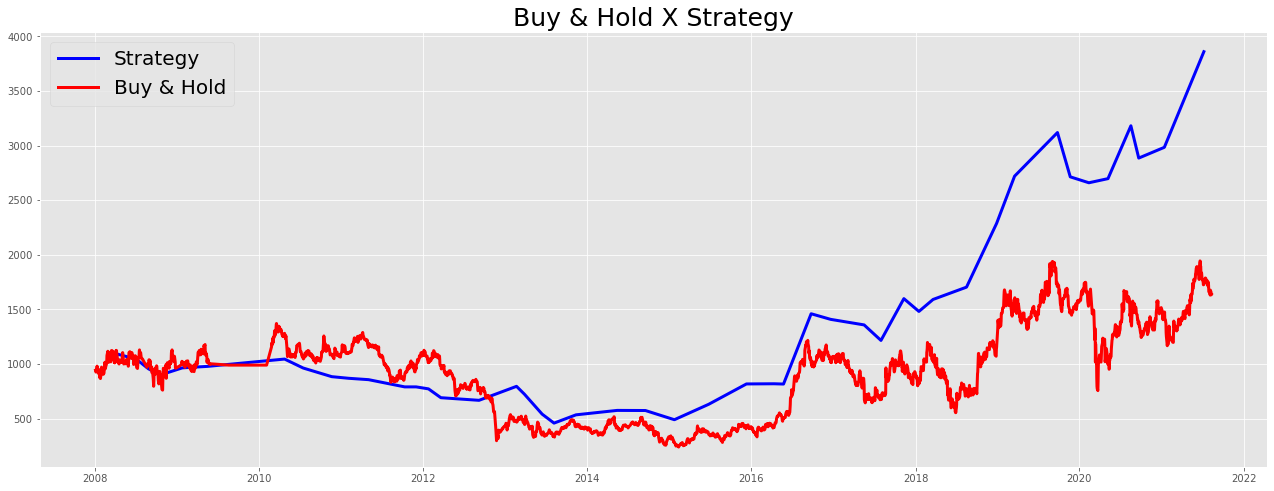

In [1279]:
plt.figure(figsize=(22,8))
plt.plot(cash_data,color="blue",label="Strategy",linewidth=3)
plt.plot(buy_hold,color="red",label="Buy & Hold",linewidth=3)
plt.title("Buy & Hold X Strategy",fontsize=25)
plt.legend(fontsize=20)
plt.show()

# Markers Plot

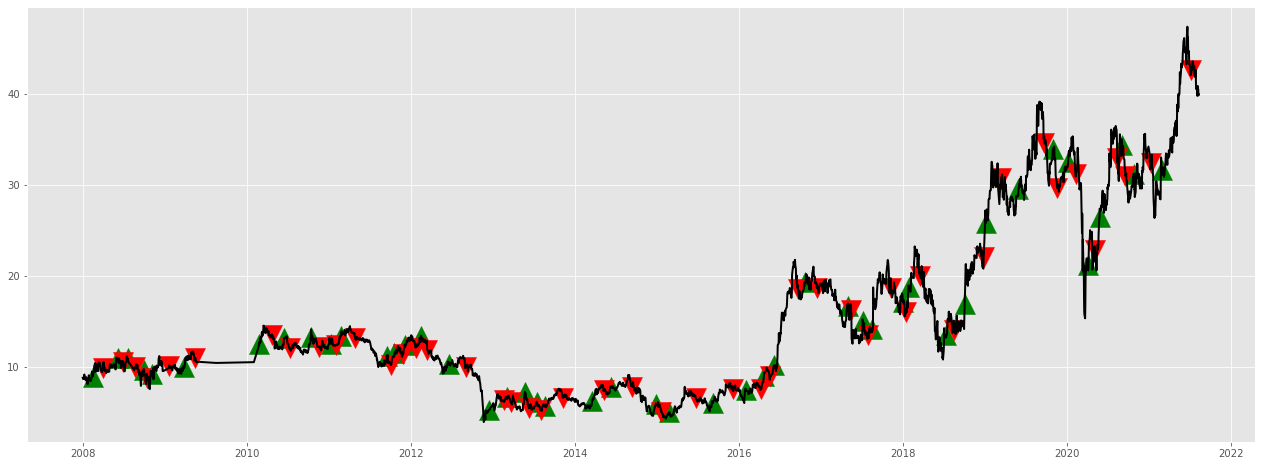

In [1280]:
plt.figure(figsize=(22,8))
plt.scatter(df.iloc[Buy].index, df.iloc[Buy]["Adj Close"], marker="^", color="green",s=400)
plt.scatter(df.iloc[Sell].index, df.iloc[Sell]["Adj Close"], marker="v", color="red",s=400)
plt.plot(df["Adj Close"], label="Price", color="k",linewidth =2)

# Final Results

In [1281]:
print(f"Period: {df.index.day[0]}/{df.index.month[0]}/{df.index.year[0]} - {df.index.day[-1]}/{df.index.month[-1]}/{df.index.year[-1]}")
print("-="*15)
strategy_return=cash_data.iloc[-2][0]/cash_data.iloc[0][0].round(2)
print(f"Strategy Total Return: {(cash_data.iloc[-2][0]/cash_data.iloc[0][0]).round(2)*100}%")
x=df["Close"][-1]/df["Close"][0]
print(f"Buy & Hold Total Return {(x*100).round(2)}% ")
print("-="*15)
print(f"Strategy Annual Return: {(((1+strategy_return)**(252/len(df))-1)*100).round(2)}%")
print(f"Buy & Hold Annual Return: {(((1+x)**(252/len(df))-1)*100).round(2)}%")
print("-="*15)
print(f"Trades: {trades}")
print(f"Trades/Year: {trades/(len(df)/252)}")
print("-="*15)
print(f"Maximum Strategy drawdown: {(((min_budget-amount)/amount)*100).round(2)}%")
print(f"Maximum Buy & Hold drawdown: {(((min(buy_hold[0])-amount)/amount)*100)}%")

Period: 2/1/2008 - 11/8/2021
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Strategy Total Return: 352.0%
Buy & Hold Total Return 173.54% 
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Strategy Annual Return: 12.83%
Buy & Hold Annual Return: 8.38%
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Trades: 46
Trades/Year: 3.6776649746192893
-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=
Maximum Strategy drawdown: -53.96%
Maximum Buy & Hold drawdown: -75.85100054740906%
